In [1]:
from imageio import imread
import numpy as np
import matplotlib.pyplot as plt

(512, 512)


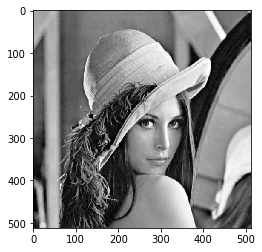

In [4]:
im = imread("lena.jpg", pilmode="L")
print(im.shape)

SIZE = [100, 100]
plt.imshow(im, cmap="gray")
plt.show()

# 1. Scaling

As a camera takes an image by **discretizing** and **quantizing** a continuous function, a computational change of the resolution can barely create the same image as a camera with the respective resolution.
This computational change is called **scaling**. 

Simple scaling consists of mapping each pixel to a new location.
As pixel coordinates are discrete, the result of the mapping must be integer coordinates.
Let $(h,w)$ be the size of the input image and $(h',w')$ the size of the output (*scaled*) image. 

1. How can the pixel coordinates $(y,x)$ in the input image can be properly mapped to new location $(y',x')$ in the ouput image?
2. Is it better to compute $(y',x')$ from $(y,x)$ or vice versa? Implement both approches and compare the results by scaling an image down and up again! 
3. Bilinear interpolation attempts to improve the quality of the scaled image. Have a look at the example implementation of function `bilinear`. Compare the results of this function with built-in function `skimage.transform.resize`.
4. Figure out, which scaling algorithm is best at reproducing the original image. How "the best" be defined mathematically (*hint: mean absolute pixel error*)? What do we need to consider about the pixel values?

# Solutions

## Task 1.1

From 
$$ \dfrac{y'}{h'} = \dfrac{y}{h}~\mathrm{and}~\dfrac{x'}{w'} = \dfrac{x}{w} $$
follows
$$ y' = y\dfrac{h'}{h}~\mathrm{and}~x' = x\dfrac{w'}{w} $$
or
$$ y = y'\dfrac{h}{h'}~\mathrm{and}~x = x'\dfrac{w}{w'} $$


## Task 1.2


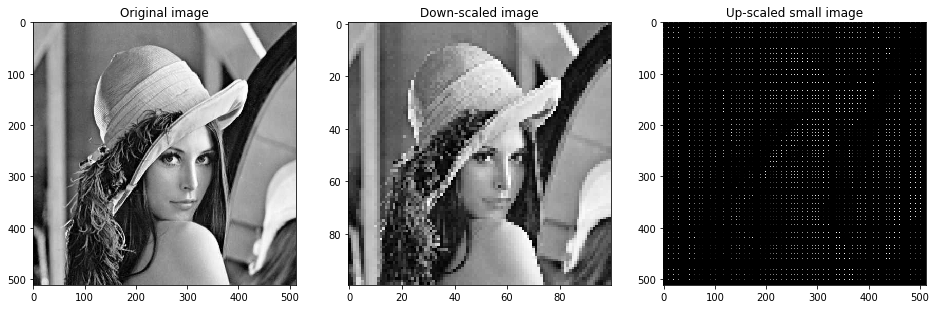

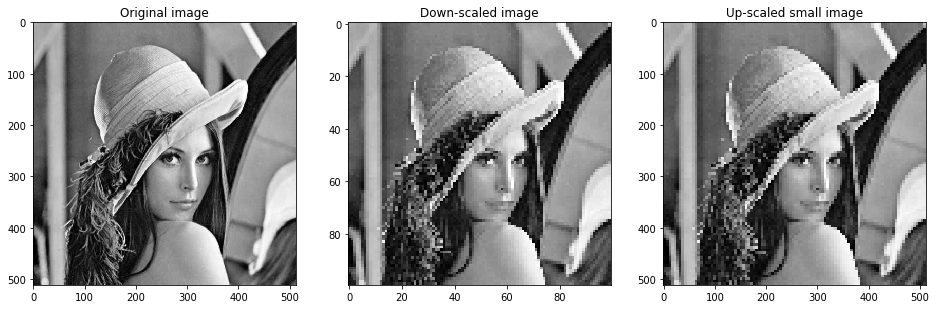

In [5]:
def scale1(im, new_size):
    """
        Here the coordinates of the INPUT image are used to compute 
        the OUTPUT coordinates
    """
    h, w = im.shape
    h_new, w_new = new_size
    
    im_new = np.zeros(new_size, dtype=im.dtype)
    
    factor_y = h_new / h
    factor_x = w_new / w
    
    for y in range(h):
        for x in range(w):
            y_new = int(y * factor_y)
            x_new = int(x * factor_x)
            
            im_new[y_new, x_new] = im[y,x]
    
    return im_new

def scale2(im, new_size):
    """
        Here the coordinates of the OUTPUT image are used to compute 
        the INPUT coordinates
    """
    h, w = im.shape
    h_new, w_new = new_size
    
    im_new = np.zeros(new_size, dtype=im.dtype)
    
    factor_y = h / h_new
    factor_x = w / w_new
    
    for y_new in range(h_new):
        for x_new in range(w_new):
            y = int(y_new * factor_y)
            x = int(x_new * factor_x)
            
            im_new[y_new, x_new] = im[y,x]
    
    return im_new

def compare_scaling(im, scale_func, new_size):
    im_small = scale_func(im, new_size)
    im_big = scale_func(im_small, im.shape)
    
    fig, axs = plt.subplots(1,3, figsize=(16,9))
        
    axs[0].imshow(im, cmap=plt.cm.gray)
    axs[0].set_title("Original image")
    
    axs[1].imshow(im_small, cmap=plt.cm.gray)
    axs[1].set_title("Down-scaled image")
    
    axs[2].imshow(im_big, cmap=plt.cm.gray)
    axs[2].set_title("Up-scaled small image")
    
    
    plt.show()
    
    
compare_scaling(im, scale1, SIZE)
compare_scaling(im, scale2, SIZE) 

## Task 1.3

In [ ]:
from skimage.transform import resize

def max_min(val, min_value, max_value):
    return max(min(val, min_value), max_value)

def bilinear(im, new_size):
    im_new = np.zeros(new_size, dtype=im.dtype)
    h, w = im.shape
    h_new, w_new = new_size
    
    factor_y = h / h_new
    factor_x = w / w_new

    for y_new in range(h_new):
        for x_new in range(w_new):
            y0 = y_new - (0.5 / factor_y + 0.5) + 1
            x0 = x_new - (0.5 / factor_x + 0.5) + 1
            # x_source, y_source is the point in the original
            # image calculated in floating point precision and
            # also in a coordinate system with origin (0,0)
            y_source = y0 * factor_y
            x_source = x0 * factor_x

            # we now simply check for boundary conditions, we want this point
            # to be strictly inside the image
            y_source = max_min(y_source, h - 1, 0)
            x_source = max_min(x_source, w - 1, 0)

            # x_source_rounded, y_source_rounded is the integer point
            # corresponding to the top-left corner of the "cell" of x_source,
            # y_source
            y_source_rounded = int(y_source)
            x_source_rounded = int(x_source)

            # we now simply check for boundary conditions again
            y_source_rounded = max_min(y_source_rounded, h - 2, 0)
            x_source_rounded = max_min(x_source_rounded, w - 2, 0)

            # we need to approximate the gray value for pixel x_source, y_source
            # and the gray values of the neighbouring pixels are

            v11 = im[y_source_rounded,     x_source_rounded    ]
            v12 = im[y_source_rounded,     x_source_rounded + 1]
            v21 = im[y_source_rounded + 1, x_source_rounded    ]
            v22 = im[y_source_rounded + 1, x_source_rounded + 1]

            # bilinear interpolation (it is actually an approximation) is
            # based on approximating the grayvalues between integer positions by
            # a plane v(x,y) = a x + b y + c x y + d
            # where we need to determine a,b,c and d from the grayvalues

            # it can be shown that the above leads leads to the following
            # estimation equation
            # a = v12 - v11
            # b = v21 - v11
            # c = v22 - v12 + v11 - v21
            # d = v11
            # bonus task: try to derive this formula by yourself

            # first, some helper variables (to get into a 0,0 to 1,1 coordinate
            # system
            xx1 = x_source - x_source_rounded
            x2x = 1 - xx1

            yy1 = y_source - y_source_rounded
            y2y = 1 - yy1

            im_new[y_new, x_new] = \
                (v11 * x2x + v12 * xx1) * y2y + \
                (v21 * x2x + v22 * xx1) * yy1
    return im_new

%time compare_scaling(im, bilinear, SIZE)
%time compare_scaling(im, resize, SIZE)

## Task 1.4

### Definition of "the best"

Given 2 images of the same size, we can define the **mean absolute pixel error** as:
$$
E(I, I') = \dfrac{1}{x*y}\sum_{x,y} |I(x,y) - I'(x,y)|
$$

In [ ]:
def _normalize(im):
    if im.dtype == np.uint8:
        im = im.astype(np.float32) / 255
    return im

def MAP_error(I, I_new):
    assert I.shape == I_new.shape, "Images must have the same shape!"
    
    I = _normalize(I)
    I_new = _normalize(I_new)
    
    abs_pixel_diff = np.abs(I - I_new)
    
    # visualize the results
    fig, axs = plt.subplots(1,3, figsize=(16,9))
        
    axs[0].imshow(I, cmap=plt.cm.gray)
    axs[0].set_title("Original image")
    
    axs[1].imshow(I_new, cmap=plt.cm.gray)
    axs[1].set_title("Rescaled image")
    
    axs[2].imshow(abs_pixel_diff)
    axs[2].set_title("Mean absolute pixel difference")
    
    # return mean error
    return abs_pixel_diff.mean()

def test_scaling(im, scale_func, new_size):
    im_small = scale_func(im, new_size)
    im_big = scale_func(im_small, im.shape)
    
    error = MAP_error(im, im_big)
    
    print("MAP-Error for {:<10s} {:.4f}".format(scale_func.__name__, error))

%time test_scaling(im, scale1, SIZE)
%time test_scaling(im, scale2, SIZE)
%time test_scaling(im, bilinear, SIZE)
%time test_scaling(im, resize, SIZE)

plt.show()    